In [1]:
%autosave 0
import numpy as np
import pandas as pd
import warnings                                 
warnings.filterwarnings('ignore')

Autosave disabled


# <center>Data Overview</center>

In [2]:
# https://www.kaggle.com/datasets/mukeshmanral/univariate-time-series
ts = pd.read_csv('date_count.csv')

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [4]:
ts

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


### Preprocessing

In [5]:
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

### Time series plot

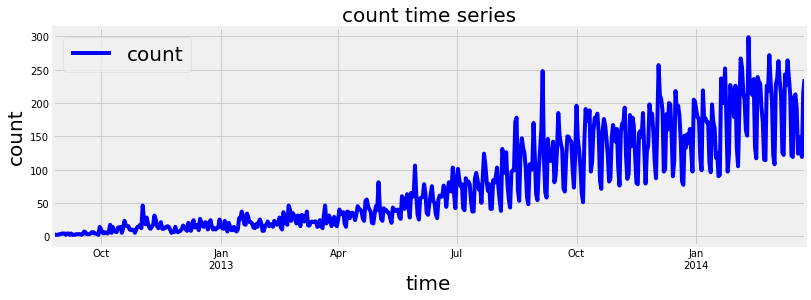

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

ts.plot(color='blue')
plt.title('count time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('count', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

### Time series decomposition

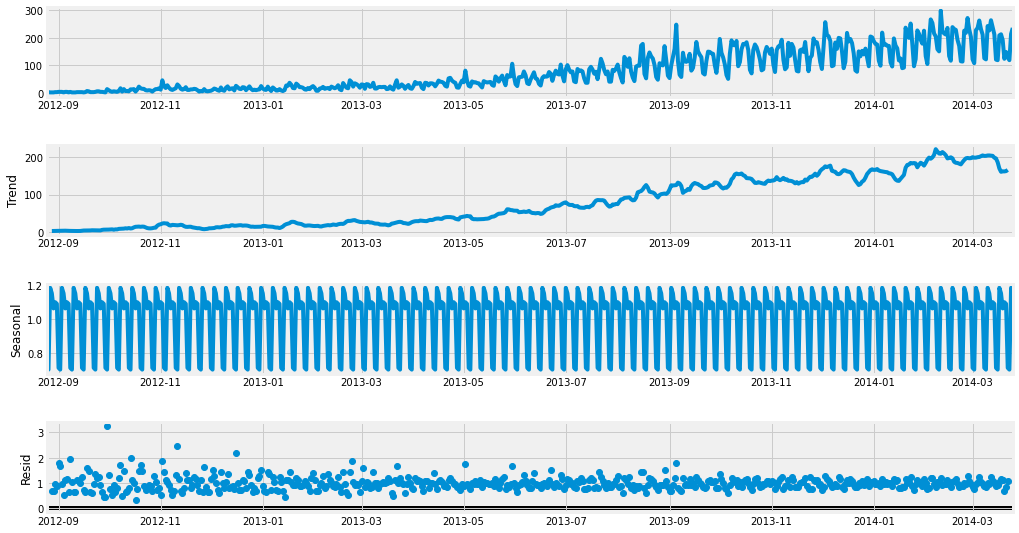

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.asfreq('D')
decompose = seasonal_decompose(ts, model='multiplicative')
decompose.plot()
plt.gcf().set_size_inches(16, 8)
plt.show()

Let's have a closer look at the seasonality.

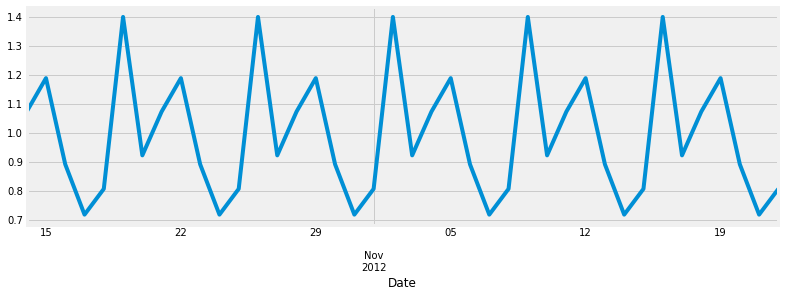

In [8]:
magified_seasonality = ts.iloc[50:90]
magified_seasonality.asfreq('D')
decomp = seasonal_decompose(magified_seasonality, model='multiplicative')
decomp.seasonal.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

It is now evident that weekly seasonality is present.

# <center>Multi-step 60-day forecast (fh = 60)</center>

### Train / test split

In [9]:
y_train = ts.iloc[:len(ts)-60]
y_test = ts.iloc[len(ts)-60:]

### Stationarity

According form the plot, trend and heteroscedasticity seems obvious. Cubic root transformation is applied.

In [10]:
y_train['y_transformed'] = np.cbrt(y_train['count'])

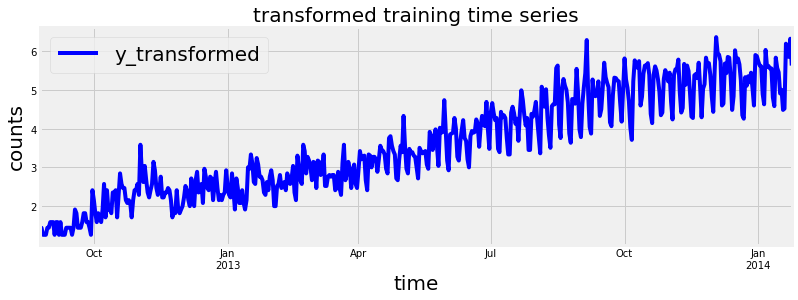

In [11]:
y_train['y_transformed'].plot(color='blue')
plt.title('transformed training time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

Heteroscedasticity appears to be pretty much gone. Trend also looks better, more linear. Let's remove it, and then have a closer look at the data. 

In [12]:
y_train['y_transformed_diff'] = y_train['y_transformed'] - y_train['y_transformed'].shift(1)
y_train.dropna(inplace=True)

In [13]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Augmented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
# adopted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80

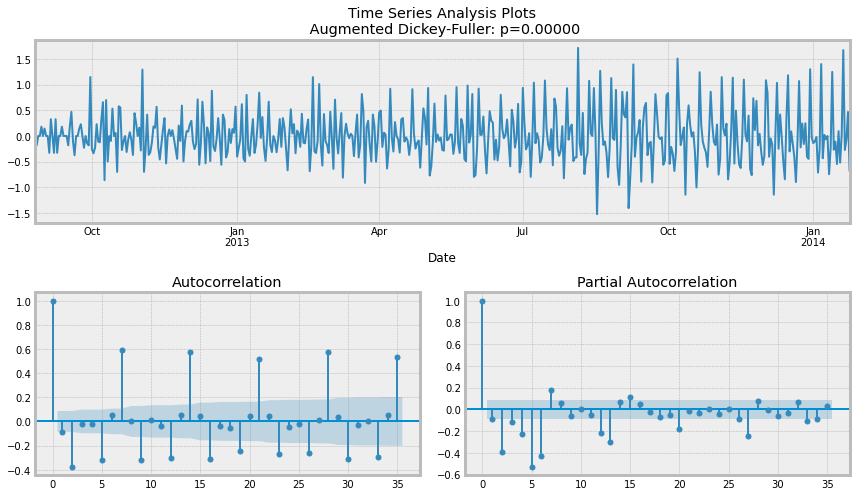

In [14]:
tsplot(y_train['y_transformed_diff'], lags=35)

ADF indicates no unit root. ACF confirms weekly seasonality. This needs some attention. Hopefully, dealing with sesonality will address the reappeared heteroscedasticity as well.   

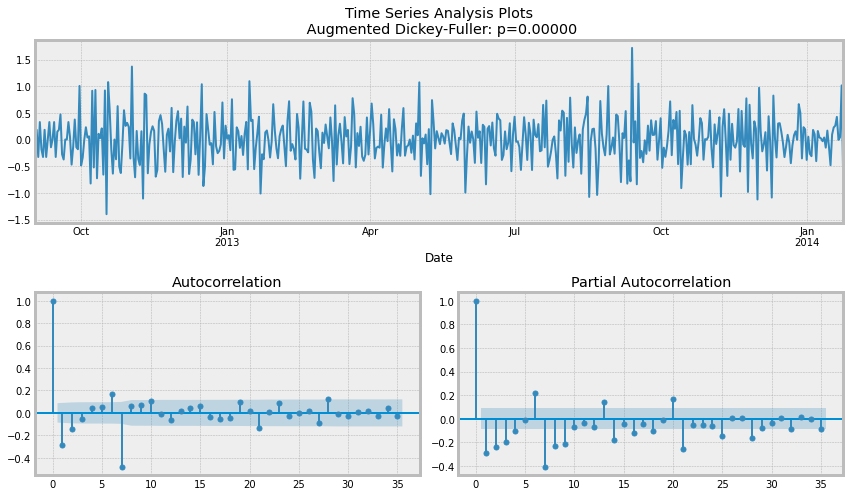

In [15]:
y_train['y_transformed_diff_sdiff'] = y_train['y_transformed_diff'] - y_train['y_transformed_diff'].shift(7)
y_train.dropna(inplace=True)
tsplot(y_train['y_transformed_diff_sdiff'], lags=35)

This time series looks fine.

* p   is most probably 3 since it is the last significant lag on the PACF, after which, most others are not significant.
* d   equals 1 because we had first differences
* q   should be most likely 2 as seen on the ACF
* P   might be 4, since lag 7-th is significant and 14-th, 21-st, 28-th lags are somewhat significant on the PACF
* D   again equals 1 because we performed seasonal differentiation
* Q   is deemed to be 1. The 7-th lag on ACF is significant while the 14-th is not
* s   is in our case 7

### Training / Forecasting

In [16]:
from kats.consts import TimeSeriesData

y_train = y_train['y_transformed']
y_train = y_train.reset_index()
y_train.columns = ["time", "value"]
y_train = TimeSeriesData(y_train)

In [17]:
from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')

params = SARIMAParams(
    p = 3, 
    d=1, 
    q=2,  
    seasonal_order=(4,1,1,7)
    )

m = SARIMAModel(data=y_train, params=params)
m.fit()

fcst = m.predict(
    steps=60, 
    freq="D"
    )

fcst.set_index('time', inplace=True)
fcst = fcst.applymap(lambda x: np.power(x,3)) # inverting to original scale
evaluation_df = fcst.assign(y_test=y_test['count'])

### Evaluation

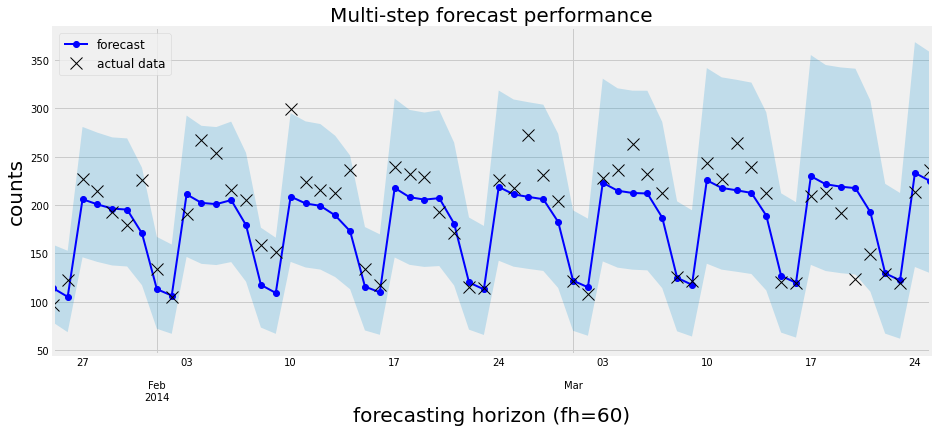

In [18]:
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Multi-step forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=60)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [19]:
def evaluation_metrics(y_test, y_pred, model_name):
    MAPE = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'Model':model_name, 'MAPE':round(MAPE,3), 'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'SARIMA')
print(accuracy)

{'Model': 'SARIMA', 'MAPE': 11.669, 'RMSE': 31.13, 'MAE': 23.04}


In [20]:
performance_summary_fh60 = pd.read_csv('performance_summary_fh60.csv')
performance_summary_fh60 = performance_summary_fh60.append(accuracy, ignore_index=True)
performance_summary_fh60.to_csv('performance_summary_fh60.csv', index=False)

# <center>Rolling 1-day forecasting (fh=1)</center>

### Data preparation

In [21]:
ts.reset_index(inplace=True)
ts.columns = ['time','value']
ts['value'] = ts['value'].map(lambda x: np.cbrt(x))
count_ts = TimeSeriesData(ts)

### Training / Forecasting

In this setup, training and forecasting is conducted one after another while the training data grows successively by 1 day.

In [22]:
evaluation_df = pd.DataFrame()
split = len(count_ts)-60

while split < len(count_ts):
    params = SARIMAParams(
    p = 3, 
    d=1, 
    q=2,  
    seasonal_order=(4,1,1,7)
    )

    m = SARIMAModel(data=count_ts[:split], params=params)
    m.fit()

    fcst = m.predict(
        steps=1, 
        freq="D"
        )
    evaluation_df = evaluation_df.append(fcst, ignore_index=True)
    split += 1

### Evaluation

In [23]:
evaluation_df.set_index('time', inplace=True)
evaluation_df = evaluation_df.applymap(lambda x: np.power(x,3)) # inverting to original scale
evaluation_df = evaluation_df.assign(y_test=y_test['count'])

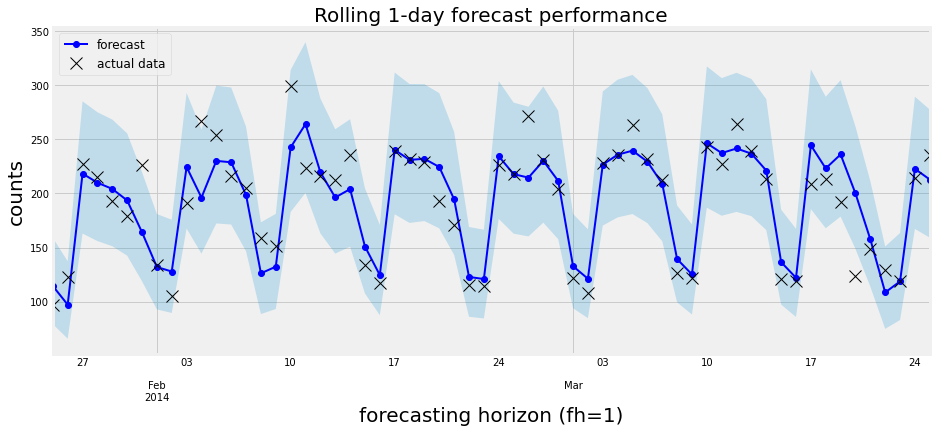

In [24]:
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Rolling 1-day forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=1)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [25]:
accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'SARIMA')
print(accuracy)

{'Model': 'SARIMA', 'MAPE': 9.673, 'RMSE': 25.091, 'MAE': 17.547}


In [26]:
performance_summary_fh1 = pd.read_csv('performance_summary_fh1.csv')
performance_summary_fh1 = performance_summary_fh1.append(accuracy, ignore_index=True)
performance_summary_fh1.to_csv('performance_summary_fh1.csv', index=False)